In [ ]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
import torchaudio
from torchaudio import datasets
import torchtext
from torchaudio.utils import download_asset

import os
import time
from tqdm import tqdm
import IPython.display as ipd

In [ ]:
!pip install lightning

In [ ]:
import lightning as L

In [ ]:
import sys
LIB_PATH = '/content/drive/MyDrive/GSC/GSC_helper'

sys.path.append(LIB_PATH)
from BCResNet import BCResNet
from utils import unzipzip, zipzip
from GSC import download_GSC
from GSC12 import SpeechCommands12

## Download Data

## GSC12 follow the original paper

In [ ]:
ZIP_MAP = download_GSC('https://drive.google.com/file/d/1-8quY_z264H0kgWqbrQPWQIvuAfioBLh/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-B1vD4fz2kZR9It2xBmq1PJ0afHnaJVg/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-CFA8mlCdT4lgnIuX4-S_Vs0ATtRBbSo/view?usp=drive_link',
                       '/content/GSC_12',
                       end = '.zip')
CSV_MAP = download_GSC('https://drive.google.com/file/d/1-DYeiWPis6npYe8Z22Sa38nB2RdokMWH/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-FB8YPbdvL2Vrhur94nWOGHL2M7RwzW0/view?usp=drive_link',
                       'https://drive.google.com/file/d/1-H7ZkCrzEl9VxfdOuH5YmCNSC6YP8CFw/view?usp=drive_link',
                       '/content/GSC_12',
                       end = '.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1-8quY_z264H0kgWqbrQPWQIvuAfioBLh
From (redirected): https://drive.google.com/uc?id=1-8quY_z264H0kgWqbrQPWQIvuAfioBLh&confirm=t&uuid=058436f7-bc09-4def-8161-49e678f34207
To: /content/GSC_12/train.zip
100%|██████████| 2.18G/2.18G [00:15<00:00, 140MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-B1vD4fz2kZR9It2xBmq1PJ0afHnaJVg
From (redirected): https://drive.google.com/uc?id=1-B1vD4fz2kZR9It2xBmq1PJ0afHnaJVg&confirm=t&uuid=4634108f-a7a1-46a5-9fb4-1f6a30da2d87
To: /content/GSC_12/val.zip
100%|██████████| 64.6M/64.6M [00:00<00:00, 132MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-CFA8mlCdT4lgnIuX4-S_Vs0ATtRBbSo
From (redirected): https://drive.google.com/uc?id=1-CFA8mlCdT4lgnIuX4-S_Vs0ATtRBbSo&confirm=t&uuid=c6a94dc1-859c-45dc-b4e7-4eb3d8cd4089
To: /content/GSC_12/test.zip
100%|██████████| 65.7M/65.7M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-DYei

## Dataset

In [ ]:
# bcresnet-3
TRAIN_TRANSFORM = torchaudio.transforms.SpecAugment(n_time_masks = 2,
                                      time_mask_param = 20,
                                      n_freq_masks = 2,
                                      freq_mask_param = 5)

In [ ]:
class GSC(torch.utils.data.Dataset):
    def __init__(self, root, subset = 'train', zip_map = None, csv_map = None, unzip = True):
        super().__init__()
        local_path = os.path.join(root, subset)
        self.root = root
        if not os.path.exists(local_path):
            os.mkdir(local_path)
            unzipzip(zip_map[subset], local_path)
        if unzip:
            unzipzip(zip_map[subset], local_path)
        self.csv = pd.read_csv(csv_map[subset])
        self.subset = subset

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        spec = np.load(os.path.join(self.root, row['link']))['arr_0']
        spec = torch.from_numpy(spec).unsqueeze(0)
        if self.subset == 'train':
            spec = TRAIN_TRANSFORM(spec)
        return spec, row['label']

    def __len__(self):
        return len(self.csv)

In [ ]:
class SC_12(L.LightningDataModule):
    def __init__(self, root, batch_size, zip_map, csv_map):
        super().__init__()
        self.root = root
        self.batch_size = batch_size
        self.train_dataset = GSC(root,
                                 subset = 'train',
                                 zip_map = zip_map,
                                 csv_map = csv_map,
                                 unzip = False)
        self.val_dataset = GSC(root,
                               subset = 'val',
                               zip_map = zip_map,
                               csv_map = csv_map,
                               unzip = False)
        self.test_dataset = GSC(root,
                                subset = 'test',
                                zip_map = zip_map,
                                csv_map = csv_map,
                                unzip = False)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = True,
    #                                       collate_fn = self.collate_fn,
                                           num_workers = 1,
                                           prefetch_factor = 1,
                                           pin_memory = True,
                                           drop_last = False)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = False,
     #                                      collate_fn = self.collate_fn,
                                           num_workers = 1,
                                           prefetch_factor = 1,
                                           pin_memory = True,
                                           drop_last = False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = False,
      #                                     collate_fn = self.collate_fn,
                                           num_workers = 1,
                                           prefetch_factor = 1,
                                           pin_memory = True,
                                           drop_last = False)

## Model

In [ ]:
class BCResNet_training(L.LightningModule):
    def __init__(self,
                 lr: float,
                 in_channels: int,
                 num_classes: int,
                 bias: bool,
                 mul_factor: int,
                 *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.save_hyperparameters()
        #self.automatic_optimization = False
        self.lr = lr
        self.net = BCResNet(in_channels,
                            num_classes,
                            bias = bias,
                            mul_factor = mul_factor)

    def forward(self, input):
        return self.net(input)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# bcresnet - 3
net = BCResNet_training(lr = 1e-3,
                        in_channels = 1,
                        num_classes = 12,
                        bias = False,
                        mul_factor = 3)
summary(net, input_size = (1, 1, 40, 101))

Layer (type:depth-idx)                                       Output Shape              Param #
BCResNet_training                                            [1, 12]                   --
├─BCResNet: 1-1                                              [1, 12]                   --
│    └─Sequential: 2-1                                       [1, 12, 1, 1]             --
│    │    └─Conv2d: 3-1                                      [1, 48, 20, 101]          1,200
│    │    └─BatchNorm2d: 3-2                                 [1, 48, 20, 101]          96
│    │    └─ReLU: 3-3                                        [1, 48, 20, 101]          --
│    │    └─BCResBlock: 3-4                                  [1, 24, 20, 101]          3,216
│    │    └─BCResBlock: 3-5                                  [1, 36, 10, 101]          4,824
│    │    └─BCResBlock: 3-6                                  [1, 48, 5, 101]           14,496
│    │    └─BCResBlock: 3-7                                  [1, 60, 5, 101]      

In [ ]:
@add_to_class(BCResNet_training)
def accuracy(self, Y_hat, Y, averaged = True):
    """
    Compute the number of correct predictions
    """
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(dim = 1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

@add_to_class(BCResNet_training)
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.forward(x)
    loss = self.loss(y_hat, y)
    acc = self.accuracy(y_hat, y)

    values = {"train_loss": loss, "train_acc": acc}
    self.log_dict(values, prog_bar = True)
    return loss

@add_to_class(BCResNet_training)
def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.forward(x)
    loss = self.loss(y_hat, y)
    acc = self.accuracy(y_hat, y)
    values = {"val_loss": loss, "val_acc": acc}
    self.log_dict(values, prog_bar = True)

@add_to_class(BCResNet_training)
def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self.forward(x)
    loss = self.loss(y_hat, y)
    acc = self.accuracy(y_hat, y)
    values = {"test_loss": loss, "test_acc": acc}
    self.log_dict(values, prog_bar = True)

@add_to_class(BCResNet_training)
def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr = 0, weight_decay = 0.00005)
    return optimizer

@add_to_class(BCResNet_training)
def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
    # update params
    optimizer.step(closure = optimizer_closure)

    # manually warm up lr without a scheduler
    warmup_epoch = 5
    try:
       self.n_step_warmup>1
    except AttributeError:
        self.total_iter = len(self.trainer.train_dataloader)*self.trainer.max_epochs
        self.n_step_warmup = len(self.trainer.train_dataloader)*warmup_epoch    # warmup epoch

    if self.trainer.global_step <= 1:
        self.total_iter = len(self.trainer.train_dataloader)*self.trainer.max_epochs
        self.n_step_warmup = len(self.trainer.train_dataloader)*warmup_epoch    # warmup epoch

    if self.trainer.global_step < self.n_step_warmup:
        lr =  self.lr*self.trainer.global_step/self.n_step_warmup
    else:
        lr = 0.5*self.lr*(1 + np.cos(np.pi*(self.trainer.global_step - self.n_step_warmup)/(self.total_iter - self.n_step_warmup)))

    for pg in optimizer.param_groups:
        pg['lr'] = lr
    self.log('lr', lr, prog_bar = True)

@add_to_class(BCResNet_training)
def configure_gradient_clipping(self, optimizer, gradient_clip_val, gradient_clip_algorithm):
    self.clip_gradients(
        optimizer,
        gradient_clip_val = gradient_clip_val,
        gradient_clip_algorithm = gradient_clip_algorithm
    )

In [ ]:
@add_to_class(BCResNet_training)
def loss(self, y_hat, y):
    return F.cross_entropy(y_hat, y, reduction = 'mean')

In [ ]:
data_12 = SC_12('/content/GSC_12', 100, ZIP_MAP, CSV_MAP)

Extracted /content/GSC_12/train.zip
Extracted /content/GSC_12/val.zip
Extracted /content/GSC_12/test.zip


In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
early_stopping_callback = EarlyStopping(monitor = "val_acc", min_delta = 0.00001, patience = 15, mode = "max")
checkpoint_callback = ModelCheckpoint(dirpath = '/content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42',
                                      save_top_k = 7, monitor = 'val_acc',
                                      mode = 'max',
                                      filename = 'bcresnet-gsc-12-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}')

## Non

In [ ]:
from lightning.pytorch import seed_everything

seed_everything(42)

net = BCResNet_training(lr = 1e-1,
                        in_channels = 1,
                        num_classes = 12,
                        bias = False,
                        mul_factor = 3)

trainer = L.Trainer(accelerator="gpu",
                    callbacks = [checkpoint_callback],
                    enable_checkpointing=True,
                    default_root_dir = "/content/drive/MyDrive/GSC_ckpt/BCResNet3/logging_random_seed_42",
                    max_epochs=200)
trainer.fit(net, data_12, ckpt_path = '/content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=92-val_loss=0.0735-val_acc=0.9757.ckpt')

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /content/drive/.shortcut-targets-by-id/1wQgfeuZWuUJYY7kQHboF_sT4yDV3eWwJ/GSC_ckpt/BCResNet3/ckpt_random_seed_42 exists and is not empty.
INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=92-val_loss=0.0735-val_acc=0.9757.ckpt
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
from lightning.pytorch import seed_everything

seed_everything(42)

net = BCResNet_training(lr = 1e-1,
                        in_channels = 1,
                        num_classes = 12,
                        bias = False,
                        mul_factor = 3)

trainer = L.Trainer(accelerator="gpu",
                    callbacks = [checkpoint_callback],
                    enable_checkpointing=True,
                    default_root_dir = "/content/drive/MyDrive/GSC_ckpt/BCResNet3/logging_random_seed_42",
                    max_epochs=200)
#trainer.fit(net, data_12, ckpt_path = '/content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=58-val_loss=0.0764-val_acc=0.9744.ckpt')

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
def test(trainer, model, dataloaders, ckpt_directory):
    ckpt_paths = os.listdir(ckpt_directory)
    loss = []
    acc = []
    for ckpt_path in ckpt_paths:
        logger = trainer.test(model = model,
                              dataloaders = dataloaders,
                              ckpt_path = os.path.join(ckpt_directory, ckpt_path),
                              verbose = False)
        loss.append(logger[0]['test_loss'])
        acc.append(logger[0]['test_acc'])
    return loss, acc, sum(loss)/len(loss), sum(acc)/len(acc)

In [ ]:
loss1, acc1, mloss1, macc1 = test(trainer, net, data_12, '/content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42')

In [ ]:
print('Max acc on Non 1 set:',max(acc1))
print('Mean acc on Non 1 ckpt set:', macc1)

Max acc on Non 1 set: 0.9766871333122253
Mean acc on Non 1 ckpt set: 0.9510079026222229


In [ ]:
acc1

[0.9756646156311035,
 0.8918200731277466,
 0.971165657043457,
 0.9742331504821777,
 0.8916155695915222,
 0.9758691191673279,
 0.9766871333122253]

In [ ]:
loss2, acc2, mloss2, macc2 = test(trainer, net, data_12, '/content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42')

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=110-val_loss=0.0670-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=110-val_loss=0.0670-val_acc=0.9773.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=110-val_loss=0.0670-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=110-val_loss=0.0670-val_acc=0.9773.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=114-val_loss=0.0668-val_acc=0.9780.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=114-val_loss=0.0668-val_acc=0.9780.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=114-val_loss=0.0668-val_acc=0.9780.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=114-val_loss=0.0668-val_acc=0.9780.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=120-val_loss=0.0688-val_acc=0.9782.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=120-val_loss=0.0688-val_acc=0.9782.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=120-val_loss=0.0688-val_acc=0.9782.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=120-val_loss=0.0688-val_acc=0.9782.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=129-val_loss=0.0688-val_acc=0.9782.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=129-val_loss=0.0688-val_acc=0.9782.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=129-val_loss=0.0688-val_acc=0.9782.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=129-val_loss=0.0688-val_acc=0.9782.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=130-val_loss=0.0685-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=130-val_loss=0.0685-val_acc=0.9773.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=130-val_loss=0.0685-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=130-val_loss=0.0685-val_acc=0.9773.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=131-val_loss=0.0672-val_acc=0.9777.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=131-val_loss=0.0672-val_acc=0.9777.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=131-val_loss=0.0672-val_acc=0.9777.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=131-val_loss=0.0672-val_acc=0.9777.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=133-val_loss=0.0703-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=133-val_loss=0.0703-val_acc=0.9773.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=133-val_loss=0.0703-val_acc=0.9773.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/GSC_ckpt/BCResNet3/ckpt_random_seed_42/bcresnet-gsc-12-epoch=133-val_loss=0.0703-val_acc=0.9773.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print('Max acc on Non 2 set:',max(acc2))
print('Mean acc on Non 2 ckpt set:', macc2)

Max acc on Non 2 set: 0.9809815883636475
Mean acc on Non 2 ckpt set: 0.9801636253084455


In [ ]:
acc2

[0.979754626750946,
 0.9803681373596191,
 0.9807771444320679,
 0.9809815883636475,
 0.9789366126060486,
 0.9799591302871704,
 0.9803681373596191]

(<Figure size 500x500 with 2 Axes>, <Axes: >)

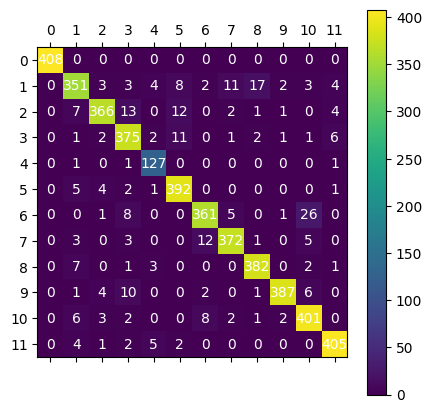

In [ ]:
plot_confmat(cofmat1, 12, 'edgecrnn_paper', '/content/drive/MyDrive/GSC_ckpt/EdgeCRNN/visualize')

In [ ]:
fnr1 = FRR_FAR(cofmat1, 7)
far1 = FRR_FAR(cofmat1, 0)
print(fnr1, far1)

6.060606241226196 0.0


In [ ]:
print('Max acc on Non 3 set:',max(acc3))
print('Mean acc on Non 3 ckpt set:', macc3)

Max acc on Non 3 set: 0.9599095582962036
Mean acc on Non 3 ckpt set: 0.9582648192133222


In [ ]:
acc3

[0.9592927694320679,
 0.9551809430122375,
 0.9584704041481018,
 0.9599095582962036,
 0.9566200971603394,
 0.9586759805679321,
 0.9597039818763733]

In [ ]:
loss4, acc4, mloss4, macc4 = test(trainer, net, data_12, '/content/drive/MyDrive/GSC_ckpt/EdgeCRNN/best_model_standard_spec_2')

In [ ]:
print('Max acc on Non 4 set:',max(acc4))
print('Mean acc on Non 4 ckpt set:', macc4)

Max acc on Non 4 set: 0.9631076455116272
Mean acc on Non 4 ckpt set: 0.960255469594683


In [ ]:
acc4

[0.9615885615348816,
 0.9583333134651184,
 0.958116352558136,
 0.958984375,
 0.9615885615348816,
 0.9631076455116272,
 0.960069477558136]

In [ ]:
confmat2 = predict(net, data_12.test_dataloader(), 12, '/content/drive/MyDrive/GSC_ckpt/EdgeCRNN/best_model_standard_spec_2/edgecrnn-gsc-12-epoch=117-val_loss=0.11-val_acc=0.9658.ckpt')


0it [00:00, ?it/s]
1it [00:09,  9.44s/it]
2it [00:17,  8.65s/it]
3it [00:23,  7.61s/it]
4it [00:29,  6.90s/it]
5it [00:36,  7.00s/it]
6it [00:43,  6.70s/it]
7it [00:50,  7.04s/it]
8it [00:57,  6.80s/it]
9it [01:03,  7.07s/it]


(<Figure size 500x500 with 2 Axes>, <Axes: >)

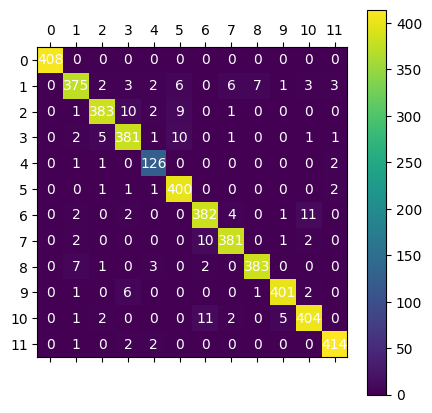

In [ ]:
plot_confmat(confmat2, 12, 'edgecrnn_paper+specaug', '/content/drive/MyDrive/GSC_ckpt/EdgeCRNN/visualize')

In [ ]:
fnr2 = FRR_FAR(confmat2, 7)
far2 = FRR_FAR(confmat2, 0)
print(fnr2, far2)

3.7878811359405518 0.0


In [ ]:
confmat3 = predict(net, data_12.test_dataloader(), 12, '/content/drive/MyDrive/GSC_ckpt/EdgeCRNN/best_model_standard_git/mdtc-gsc-12-epoch=59-val_loss=0.13-val_acc=0.9598.ckpt')

In [ ]:
from torch import Tensor

def FRR_FAR(cofmat: Tensor,
            label_index: int):
    sum_ = sum(cofmat[label_index, :])
    res = 1-(cofmat[label_index, label_index])/sum_
    return res.item()*100

In [ ]:
from GSC_eval import predict, plot_confmat

In [ ]:
a = torch.Tensor(3,3)
FRR_FAR(a, 1)

0.6625766754150391

In [ ]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

In [ ]:
losses = []
accs = []
epochs = []
for summary in summary_iterator("/content/mdtc1/lightning_logs/version_0/events.out.tfevents.1710942302.83bc5cce5f93.436.0"):
    ss = summary.summary.value
    for s in ss:
      if s.tag == 'train_loss':
          losses.append(s.simple_value)
      if s.tag == 'epochs':
          epochs.append(s.simple_value)
      if s.tag == 'val_acc':
          accs.append(s.simple_value)

In [ ]:
epochs

[]

In [ ]:
max(accs)

0.9558503031730652